In [1]:
#Martha Czernuszenko's code
#Packages needed 
import pandas as pd 
import numpy as np 
import pickle 
import matplotlib.pyplot as plt 
import time 
 
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer 


In [2]:
#Code is from topic_tune_LDA
 
# FUNCTIONS NEEDED FOR ALL MODELS  ============================================ 
 
# function slightly modified from https://nlpforhackers.io/topic-modeling/ 
 
def print_topics(model, tfidf_vectorizer, top_n=10): 
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row 
        print("\\nTopic %d:" % (idx)) 
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line 
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic 
             
        print_list = [(tfidf_vectorizer.get_feature_names()[i], topic[i])   
                        for i in topic.argsort()[:-top_n - 1:-1]] 
        for item in print_list: 
            print(item) 
            

In [174]:
# DATA INGESTION ========================================================= 
#Import dataframe (Edit to fit the corpus/datafame)

#Full dataset
df = pd.read_pickle('../../data/final/final_dataset_7-20.pkl')

#Corpus
#df = pd.read_pickle('../../data/final/dashboard_data/pandemic_corpus.pkl')


# Cleaning for Start Date here and End Date
#We need to get the years for each one

In [175]:
#Check indexes, in corpus, these indexes don't start at 0, rather are numbers from the original corpus. Therefore, we need to reset the indexes on the corpus to merge later
df['PROJECT_START_DATE']

0         12/1/2005
1          9/1/2007
2          1/2/2007
3          4/1/2006
4         10/1/2009
            ...    
690850    9/10/2018
690851    9/10/2019
690852    9/10/2018
690853    9/10/2019
690854    9/10/2018
Name: PROJECT_START_DATE, Length: 690814, dtype: object

In [176]:
#Reset indexes to merge
#You don't need to reset the index if you are running topics on the full dataset
df = df.reset_index(drop=True)

In [177]:
#Check merge
df['PROJECT_START_DATE']

0         12/1/2005
1          9/1/2007
2          1/2/2007
3          4/1/2006
4         10/1/2009
            ...    
690809    9/10/2018
690810    9/10/2019
690811    9/10/2018
690812    9/10/2019
690813    9/10/2018
Name: PROJECT_START_DATE, Length: 690814, dtype: object

In [178]:
#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year
df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [179]:
#Check - you will use this number to make sure merges were correct etc.
len(df['START_YEAR'])

690814

In [180]:
#Just in case
df['START_YEAR'] = df['START_YEAR'].dropna()

In [181]:
len(df['START_YEAR'])

690814

In [182]:
#End Year

df['END_YEAR'] = df['PROJECT_END_DATE'].apply(getYear)

In [183]:
df['END_YEAR'].value_counts()

2013    62550
2015    61437
2012    57661
2019    56754
2016    56344
2014    53761
2011    52149
2017    52052
2018    48017
2010    43007
2020    42249
2009    30961
2021    25376
2008    15227
2022    14671
2023    11513
2024     6531
2025      224
2007      176
2026      109
2027       23
2028       14
2006        3
2029        3
3018        1
2005        1
Name: END_YEAR, dtype: int64

In [184]:
#These are the words that you will use for topic modeling
df['final_frqwds_removed']

0         [multiprotein, y_secretase, proteolytically_cl...
1         [kissl, gene, encode, peptide, kisspeptin, bin...
2         [biophysical, basis, thermodynamics_kinetic, m...
3         [obesity, adverse_pregnancyoutcome, great, hea...
4         [local, potato, advisory, express, interest, m...
                                ...                        
690809    [pathophysiology, schizophrenia, advance, thed...
690810    [alzheimer, ad, amyotrophic_lateral_sclerosis_...
690811    [highest, mortality, acute, care, encounter, r...
690812    [paradigm, kidney, largely, stagnant, decade, ...
690813    [division, intramural, population, health, dip...
Name: final_frqwds_removed, Length: 690814, dtype: object

In [185]:
#Function to find top n words across all abstracts - needs to be a string format 
def AbstractToString(token_list, seperator=','):
    return seperator.join(token_list)
df['string_of_tokens'] = df['final_frqwds_removed'].apply(AbstractToString)

In [186]:
#Create docs
docs = df["string_of_tokens"] 

In [187]:
#Check if length matches startdate length
len(docs)

690814

In [188]:
#Created a document-term matrix and run model

In [189]:
###########
# CREATE DOC-TERM MATRIX  ============================================================================ 
 
#vectorizer =CountVectorizer(max_df=1.0, min_df=3, lowercase=True, max_features=int(len(docs)/2)) 
# doc_term_matrix= vectorizer.fit_transform(docs) 

#Use this vectrorizer on full dataset
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
tf_idf = tfidf_vectorizer.fit_transform(docs)

#Run NMF on these at 30 topics with random_state = 1.  These are the parameters for both runs. Also use the following for the tfidf vectorizer params:
#nmf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=True)

#Use this vectorizer on corpus
#tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=True) 
#tf_idf = tfidf_vectorizer.fit_transform(docs)
 
# input needed for LDA, NMF and LSA (all from Scikit-Learn) is one string per document (not a list of strings) 
 
#text = [] 
#for doc in docs: 
#    text.append(" ".join(doc)) 


In [190]:
######## 
# NMF RUNS ===================================================================================

#Left LDA in comments if we ever want to switch
 
# function adapted from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/ 
i = 9000 

num_topics = 75
 
# create model 
t1 = time.time() 
#lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics,  
                                      #topic_word_prior=0.1, n_jobs=39, random_state = i) 
#lda_model.fit_transform(doc_term_matrix) 



nmf_model = NMF(n_components=num_topics, random_state = 1)
nmf_model.fit_transform(tf_idf)
t2 = time.time() 
print(f"  Model time:  {t2-t1 }") 
 
# print out topics - change later to 5
topics = print_topics(nmf_model, tfidf_vectorizer, top_n=10) 


  Model time:  1430.331421136856
\nTopic 0:
('cell', 58.588817933922456)
('differentiation', 3.891691352796734)
('cellular', 2.869268675665262)
('culture', 2.5709354257120633)
('proliferation', 2.414099827195478)
('antigen', 2.3371204253124325)
('cd4', 2.2634690896426823)
('line', 2.2512260566569777)
('progenitor', 2.1360166384319568)
('migration', 2.1156282552060937)
\nTopic 1:
('student', 11.896175286840707)
('undergraduate', 2.8446680967348343)
('graduate', 2.7248654418560383)
('college', 1.6614544881853004)
('faculty', 1.460029190311198)
('course', 1.3433567590751705)
('summer', 1.3079361381815027)
('reu', 1.2250148963231802)
('career', 1.187463683963851)
('school', 0.9928380062555668)
\nTopic 2:
('cancer', 9.633686363664385)
('nci', 0.6226903015602685)
('pancreatic', 0.525047899830736)
('member', 0.5142669295077376)
('ovarian', 0.5012649337499326)
('prevention', 0.4947941647668285)
('colorectal', 0.4153482289621902)
('colon', 0.3476440742333719)
('oncology', 0.32090145391020525)
(

In [191]:
#Now we have a list of topics. In order to add a column of top ten words to the final dataframe, we need to transform the list into a dataframe
#Given the time constraint, I did this in Excel. The result of manipulation and rearrainging is pandemicsINPUT.CSV

In [192]:
#To be able to create csv
break

SyntaxError: 'break' outside loop (<ipython-input-192-5f0b253d08f2>, line 5)

# This starts the paper's methods on ranking criteria. The paper states 2 different ranking critieria. I have both included, but the paper decides to go with Ranking Critieria #1. 

In [ ]:
#Ranking Critera #2 
#Ranking Critera #2: The number of articles in which each topic has the highest proportion
#The paper defines 2 approaches. They go with the other one, but coded this one out in case we want to compare results.


In [193]:
#List of Topic Probabilites for each document
#https://stackoverflow.com/questions/35252762/finding-number-of-documents-per-topic-for-lda-with-scikit-learn
#Ranking Critera #2: The number of articles in which each topic has the highest proportion

#Weights 
docsVStopics = nmf_model.transform(tf_idf)
docsVStopics = pd.DataFrame(docsVStopics, columns=["Topic"+" "+str(i) for i in range(num_topics)])
print("Created a (%dx%d) document-topic matrix." % (docsVStopics.shape[0], docsVStopics.shape[1]))
docsVStopics.head()

Created a (690814x75) document-topic matrix.


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
0,0.000000,0.0,0.000157,0.0,0.0,0.001204,0.000000,0.000000,0.0,0.001495,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.001186,0.000000,0.0,0.000000
1,0.000000,0.0,0.000000,0.0,0.0,0.000788,0.001415,0.000000,0.0,0.000492,...,0.000000,0.0,0.000000,0.000000,0.000000,0.002313,0.000000,0.000813,0.0,0.000000
2,0.000000,0.0,0.000087,0.0,0.0,0.000000,0.000371,0.000000,0.0,0.004561,...,0.000758,0.0,0.000000,0.000966,0.000000,0.000000,0.000000,0.000000,0.0,0.000376
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000515,0.0,0.000000,...,0.000000,0.0,0.008982,0.028247,0.000000,0.057309,0.000000,0.000000,0.0,0.000000
4,0.000027,0.0,0.000000,0.0,0.0,0.000000,0.000071,0.004054,0.0,0.000102,...,0.000819,0.0,0.000214,0.000000,0.005635,0.000000,0.000713,0.001575,0.0,0.000000


In [194]:
#Check: does the length match the original number of docs
#This matches the length for docs
len(docsVStopics)

690814

In [195]:
#Counter for the # of articles in which topic has highest proportion
m = np.zeros_like(docsVStopics.values)
m[np.arange(len(docsVStopics)), docsVStopics.values.argmax(1)] = 1

rankings = pd.DataFrame(m, columns = docsVStopics.columns).astype(int)

In [196]:
#Get the rankings
rankings

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
690810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
690811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
690812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [197]:
sums = rankings.sum()

In [198]:
sums

Topic 0      1027
Topic 1     13812
Topic 2     23413
Topic 3      9193
Topic 4     19742
            ...  
Topic 70    14629
Topic 71    22422
Topic 72    13037
Topic 73    12099
Topic 74    36718
Length: 75, dtype: int64

In [199]:
#Check if this worked
sums.sum()

690814

In [200]:
ranked_num_of_articles = sums.rank()
ranked_num_of_articles

#This is 1/2 of the ranking system

Topic 0      1.0
Topic 1     66.0
Topic 2     73.0
Topic 3     44.0
Topic 4     71.0
            ... 
Topic 70    67.0
Topic 71    72.0
Topic 72    61.0
Topic 73    56.0
Topic 74    75.0
Length: 75, dtype: float64

In [201]:
#The next 2 cells are optional: these are if we ever want any additioanl details.

In [202]:
#Getting the most likely topic for each document
#https://stackoverflow.com/questions/35252762/finding-number-of-documents-per-topic-for-lda-with-scikit-learn
#most_likely_topics = docsVStopics.idxmax(axis=1)


In [203]:
#Get the counts
#most_likely_topics.groupby(most_likely_topics).count()

This next section is the ranking Criteria #1 (what the paper recommends)
Ranking Critera #1: #Topics in a descending order of proprotion in the whole collection of articles:

In [204]:
#Ranking Criteria #1
#Topics in a descending order of proprotion in the whole collection of articles:
#docsVStopics
#proportion = docsVStopics.mean()
#Fractional assignment: % that topic is in all of documents?

In [205]:
#rank_proportion = proportion.rank()
#rank_proportion 

In [206]:
#rank_proportion
#DocsVStopics is from above
docsVStopics

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
0,0.000000,0.000000,0.000157,0.000000,0.000000,0.001204,0.000000,0.000000,0.000000,0.001495,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001186,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000788,0.001415,0.000000,0.000000,0.000492,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002313,0.000000,0.000813,0.000000,0.000000
2,0.000000,0.000000,0.000087,0.000000,0.000000,0.000000,0.000371,0.000000,0.000000,0.004561,...,0.000758,0.000000,0.000000,0.000966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000376
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000515,0.000000,0.000000,...,0.000000,0.000000,0.008982,0.028247,0.000000,0.057309,0.000000,0.000000,0.000000,0.000000
4,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000071,0.004054,0.000000,0.000102,...,0.000819,0.000000,0.000214,0.000000,0.005635,0.000000,0.000713,0.001575,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690809,0.000000,0.000011,0.000048,0.000000,0.000000,0.001261,0.001602,0.000000,0.005045,0.000000,...,0.000000,0.000000,0.000000,0.000629,0.000000,0.000530,0.000000,0.000000,0.000000,0.000000
690810,0.000000,0.000047,0.000000,0.000071,0.000000,0.000000,0.000000,0.000181,0.000000,0.000000,...,0.000000,0.001235,0.000387,0.000000,0.001192,0.000000,0.000000,0.000869,0.000793,0.000000
690811,0.000000,0.009414,0.000000,0.000000,0.000089,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000440,0.000010,0.038401,0.000000,0.000681,0.000000,0.000000,0.000000
690812,0.000865,0.000000,0.000000,0.000000,0.000000,0.001258,0.000000,0.000869,0.000000,0.000000,...,0.000000,0.000000,0.003204,0.000000,0.000000,0.000000,0.000000,0.000000,0.023937,0.000000


In [207]:
#Get start year! 
docsVStopics["START_YEAR"] = df["START_YEAR"]
docsVStopics["START_YEAR"].value_counts()

2009    70341
2010    65365
2011    59286
2008    56170
2012    51579
2014    45773
2016    44917
2015    44798
2013    44227
2018    43224
2017    41733
2019    31166
2007    17863
2006    10504
2005     9521
2004     8038
2003     5093
1997     4507
2002     4486
2001     4406
2000     3635
1999     3475
1998     2677
1996     1851
1994     1598
1995     1436
1992     1269
1993     1179
1991     1136
1988      913
1990      845
1989      840
1987      704
1986      675
1985      665
1978      639
1983      637
1984      598
1977      506
1975      490
1979      463
1980      438
1982      393
1981      341
1976      336
2020       33
1974       32
1970        4
1972        4
1965        4
1973        1
Name: START_YEAR, dtype: int64

In [208]:
#Weights
#Here is where we calculate the regression per start year 
docsVStopics = docsVStopics.groupby("START_YEAR").mean().reset_index()
ordered_docsVStopics =docsVStopics.sort_values(by = "START_YEAR")

In [209]:
#Ranking
ordered_docsVStopics

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
0,1965,0.001409,0.000000,0.000033,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001743,0.000223,0.003988,0.000137,0.000000,0.000000,0.000982,0.000357,0.000368
1,1970,0.000000,0.000000,0.000000,0.000000,0.000431,0.001168,0.000864,0.000206,0.000034,...,0.000617,0.000039,0.000000,0.000000,0.000000,0.000000,0.000395,0.000000,0.003407,0.000000
2,1972,0.000012,0.000637,0.000354,0.000032,0.000176,0.000000,0.001260,0.000000,0.000164,...,0.000022,0.000348,0.000076,0.000077,0.000000,0.000044,0.004135,0.000081,0.000037,0.000000
3,1973,0.000065,0.000000,0.000000,0.000148,0.000047,0.000089,0.000000,0.000000,0.000607,...,0.000000,0.004794,0.000000,0.003666,0.000000,0.000041,0.000000,0.000000,0.000000,0.000000
4,1974,0.001078,0.000120,0.000481,0.000635,0.000026,0.000521,0.000346,0.000078,0.000297,...,0.000700,0.000028,0.000607,0.000936,0.000004,0.001009,0.000327,0.000143,0.000374,0.000365
5,1975,0.000453,0.007681,0.002264,0.000018,0.000209,0.000933,0.001236,0.000141,0.000121,...,0.000535,0.000157,0.001691,0.000999,0.001106,0.000770,0.005371,0.000236,0.000829,0.000332
6,1976,0.000503,0.001301,0.002318,0.000035,0.000626,0.000760,0.000492,0.000336,0.000246,...,0.000696,0.000151,0.001143,0.000913,0.001390,0.000531,0.003738,0.000216,0.000661,0.000631
7,1977,0.000597,0.003374,0.001967,0.000116,0.000541,0.000759,0.000569,0.000253,0.000288,...,0.000474,0.000283,0.002057,0.001808,0.000940,0.000633,0.003863,0.000611,0.000534,0.000522
8,1978,0.000523,0.002085,0.004634,0.000073,0.000403,0.000887,0.001146,0.000311,0.000241,...,0.000563,0.000142,0.001413,0.000924,0.000849,0.000572,0.004447,0.000581,0.000564,0.000933
9,1979,0.000546,0.002480,0.002107,0.000120,0.000419,0.000982,0.000620,0.000399,0.000629,...,0.001833,0.000110,0.000583,0.000968,0.000491,0.000704,0.003993,0.000584,0.000482,0.000532


In [210]:
#Get data frame ready for ranking
#You can't have start year in the dataframe or the ranking will also rank the start year
ordered_docsVStopics_no_year = ordered_docsVStopics.drop(['START_YEAR'], axis=1)
ordered_docsVStopics_no_year

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
0,0.001409,0.000000,0.000033,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.008669,...,0.000000,0.001743,0.000223,0.003988,0.000137,0.000000,0.000000,0.000982,0.000357,0.000368
1,0.000000,0.000000,0.000000,0.000000,0.000431,0.001168,0.000864,0.000206,0.000034,0.000938,...,0.000617,0.000039,0.000000,0.000000,0.000000,0.000000,0.000395,0.000000,0.003407,0.000000
2,0.000012,0.000637,0.000354,0.000032,0.000176,0.000000,0.001260,0.000000,0.000164,0.000000,...,0.000022,0.000348,0.000076,0.000077,0.000000,0.000044,0.004135,0.000081,0.000037,0.000000
3,0.000065,0.000000,0.000000,0.000148,0.000047,0.000089,0.000000,0.000000,0.000607,0.000455,...,0.000000,0.004794,0.000000,0.003666,0.000000,0.000041,0.000000,0.000000,0.000000,0.000000
4,0.001078,0.000120,0.000481,0.000635,0.000026,0.000521,0.000346,0.000078,0.000297,0.006845,...,0.000700,0.000028,0.000607,0.000936,0.000004,0.001009,0.000327,0.000143,0.000374,0.000365
5,0.000453,0.007681,0.002264,0.000018,0.000209,0.000933,0.001236,0.000141,0.000121,0.001191,...,0.000535,0.000157,0.001691,0.000999,0.001106,0.000770,0.005371,0.000236,0.000829,0.000332
6,0.000503,0.001301,0.002318,0.000035,0.000626,0.000760,0.000492,0.000336,0.000246,0.002821,...,0.000696,0.000151,0.001143,0.000913,0.001390,0.000531,0.003738,0.000216,0.000661,0.000631
7,0.000597,0.003374,0.001967,0.000116,0.000541,0.000759,0.000569,0.000253,0.000288,0.004149,...,0.000474,0.000283,0.002057,0.001808,0.000940,0.000633,0.003863,0.000611,0.000534,0.000522
8,0.000523,0.002085,0.004634,0.000073,0.000403,0.000887,0.001146,0.000311,0.000241,0.003833,...,0.000563,0.000142,0.001413,0.000924,0.000849,0.000572,0.004447,0.000581,0.000564,0.000933
9,0.000546,0.002480,0.002107,0.000120,0.000419,0.000982,0.000620,0.000399,0.000629,0.003740,...,0.001833,0.000110,0.000583,0.000968,0.000491,0.000704,0.003993,0.000584,0.000482,0.000532


In [211]:
#RANKING HAPPENS HERE!!!

In [212]:
rankdf = ordered_docsVStopics_no_year.rank(1, ascending=True, method='first')
rankdf
#Larger number means bigger value-will show up higher in graph
#If we want to change the logic, as the largest number is 1, change ascending parameter = False

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
0,61.0,1.0,33.0,30.0,2.0,3.0,4.0,5.0,6.0,73.0,...,25.0,63.0,45.0,67.0,40.0,26.0,27.0,58.0,50.0,51.0
1,1.0,2.0,3.0,4.0,53.0,63.0,60.0,47.0,33.0,61.0,...,56.0,35.0,24.0,25.0,26.0,27.0,50.0,28.0,72.0,29.0
2,32.0,65.0,61.0,37.0,53.0,1.0,66.0,2.0,52.0,3.0,...,33.0,60.0,44.0,45.0,24.0,40.0,73.0,46.0,38.0,25.0
3,48.0,1.0,2.0,53.0,45.0,50.0,3.0,4.0,65.0,61.0,...,31.0,74.0,32.0,72.0,33.0,42.0,34.0,35.0,36.0,37.0
4,61.0,21.0,48.0,53.0,11.0,49.0,40.0,18.0,37.0,73.0,...,55.0,13.0,51.0,57.0,1.0,60.0,39.0,24.0,44.0,43.0
5,46.0,74.0,70.0,4.0,29.0,58.0,67.0,19.0,17.0,64.0,...,49.0,22.0,69.0,60.0,63.0,55.0,73.0,34.0,56.0,39.0
6,36.0,65.0,71.0,1.0,43.0,50.0,34.0,26.0,20.0,73.0,...,48.0,10.0,62.0,58.0,66.0,39.0,74.0,18.0,45.0,44.0
7,44.0,72.0,68.0,6.0,37.0,54.0,40.0,19.0,23.0,74.0,...,29.0,21.0,70.0,67.0,59.0,47.0,73.0,46.0,34.0,32.0
8,32.0,71.0,75.0,3.0,27.0,53.0,60.0,22.0,17.0,73.0,...,35.0,8.0,65.0,56.0,51.0,37.0,74.0,38.0,36.0,57.0
9,40.0,72.0,71.0,5.0,28.0,57.0,44.0,26.0,46.0,74.0,...,69.0,4.0,42.0,56.0,33.0,50.0,75.0,43.0,32.0,37.0


In [213]:
#Created yearsdf to merge later
ordered_docsVStopics_year_only = ordered_docsVStopics['START_YEAR']
yeardf = pd.DataFrame(ordered_docsVStopics_year_only)
yeardf

,START_YEAR
0,1965
1,1970
2,1972
3,1973
4,1974
5,1975
6,1976
7,1977
8,1978
9,1979


In [214]:
#Merge ranks by year
mergeddf = rankdf.merge(yeardf, left_index=True, right_index=True)
mergeddf

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74,START_YEAR
0,61.0,1.0,33.0,30.0,2.0,3.0,4.0,5.0,6.0,73.0,...,63.0,45.0,67.0,40.0,26.0,27.0,58.0,50.0,51.0,1965
1,1.0,2.0,3.0,4.0,53.0,63.0,60.0,47.0,33.0,61.0,...,35.0,24.0,25.0,26.0,27.0,50.0,28.0,72.0,29.0,1970
2,32.0,65.0,61.0,37.0,53.0,1.0,66.0,2.0,52.0,3.0,...,60.0,44.0,45.0,24.0,40.0,73.0,46.0,38.0,25.0,1972
3,48.0,1.0,2.0,53.0,45.0,50.0,3.0,4.0,65.0,61.0,...,74.0,32.0,72.0,33.0,42.0,34.0,35.0,36.0,37.0,1973
4,61.0,21.0,48.0,53.0,11.0,49.0,40.0,18.0,37.0,73.0,...,13.0,51.0,57.0,1.0,60.0,39.0,24.0,44.0,43.0,1974
5,46.0,74.0,70.0,4.0,29.0,58.0,67.0,19.0,17.0,64.0,...,22.0,69.0,60.0,63.0,55.0,73.0,34.0,56.0,39.0,1975
6,36.0,65.0,71.0,1.0,43.0,50.0,34.0,26.0,20.0,73.0,...,10.0,62.0,58.0,66.0,39.0,74.0,18.0,45.0,44.0,1976
7,44.0,72.0,68.0,6.0,37.0,54.0,40.0,19.0,23.0,74.0,...,21.0,70.0,67.0,59.0,47.0,73.0,46.0,34.0,32.0,1977
8,32.0,71.0,75.0,3.0,27.0,53.0,60.0,22.0,17.0,73.0,...,8.0,65.0,56.0,51.0,37.0,74.0,38.0,36.0,57.0,1978
9,40.0,72.0,71.0,5.0,28.0,57.0,44.0,26.0,46.0,74.0,...,4.0,42.0,56.0,33.0,50.0,75.0,43.0,32.0,37.0,1979


Changing the dataframe for graphing

In [215]:
#This is what is implemented on the R Shiny App 

In [216]:
#Melt to get the data for graphing purposes 
newdf = docsVStopics.melt(id_vars =['START_YEAR'], var_name = "Topic", value_name = "Weight")

In [217]:
newdf

,START_YEAR,Topic,Weight
0,1965,Topic 0,0.001409
1,1970,Topic 0,0.000000
2,1972,Topic 0,0.000012
3,1973,Topic 0,0.000065
4,1974,Topic 0,0.001078
...,...,...,...
3820,2016,Topic 74,0.002663
3821,2017,Topic 74,0.002711
3822,2018,Topic 74,0.002750
3823,2019,Topic 74,0.001852


In [218]:
#This is where you merge the current dataframe with the Excel file of top 10 words per topic

In [219]:
#Merge

#Import excel file with words
worddf = pd.read_csv("seventyfivetopics_INPUT.csv")

In [220]:
#Make 1 column of the top 10 words
worddf['Top 10 Words'] = worddf['Word 1'] + ","+worddf['Word 2']+ ","+worddf['Word 3']+ ","+worddf['Word 4']+ ","+worddf['Word 5']+ ","+worddf['Word 6']+ ","+worddf['Word 7']+ ","+worddf['Word 8']+ ","+worddf['Word 9']+ ","+worddf['Word 10']
worddf

,Topic,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Top 10 Words
0,Topic 0,cell,differentiation,cellular,culture,proliferation,antigen,cd4,line,progenitor,migration,"cell,differentiation,cellular,culture,prolifer..."
1,Topic 1,student,undergraduate,graduate,college,faculty,course,summer,reu,career,school,"student,undergraduate,graduate,college,faculty..."
2,Topic 2,cancer,nci,pancreatic,member,ovarian,prevention,colorectal,colon,oncology,incidence,"cancer,nci,pancreatic,member,ovarian,preventio..."
3,Topic 3,hiv,aids,infect,prevention,cfar,antiretroviral,art,cd4,transmission,viral,"hiv,aids,infect,prevention,cfar,antiretroviral..."
4,Topic 4,infection,infect,viral,hpv,tb,hcv,chronic,acute,parasite,siv,"infection,infect,viral,hpv,tb,hcv,chronic,acut..."
...,...,...,...,...,...,...,...,...,...,...,...,...
69,Topic 70,woman,pregnancy,man,hpv,female,maternal,reproductive,ovarian,infant,cervical,"woman,pregnancy,man,hpv,female,maternal,reprod..."
70,Topic 71,pilot,faculty,grant,funding,fund,member,cobre,junior,institution,award,"pilot,faculty,grant,funding,fund,member,cobre,..."
71,Topic 72,il,cytokine,inflammation,asthma,inflammatory,macrophage,production,airway,th2,activation,"il,cytokine,inflammation,asthma,inflammatory,m..."
72,Topic 73,injury,tbi,recovery,traumatic,acute,kidney,sci,trauma,damage,stroke,"injury,tbi,recovery,traumatic,acute,kidney,sci..."


In [221]:
#Check column names
worddf.columns

Index(['Topic', 'Word 1', 'Word 2', 'Word 3', 'Word 4', 'Word 5', 'Word 6',
       'Word 7', 'Word 8', 'Word 9', 'Word 10', 'Top 10 Words'],
      dtype='object')

In [222]:
#Created a condensed dataframe because we don't need words in other columns
condenseddf =  worddf[['Topic','Top 10 Words']].copy()
condenseddf.columns

Index(['Topic', 'Top 10 Words'], dtype='object')

In [223]:
#Merge
finaldf = pd.merge(newdf, condenseddf, left_on = 'Topic', right_on = 'Topic')
finaldf

,START_YEAR,Topic,Weight,Top 10 Words
0,1965,Topic 0,0.001409,"cell,differentiation,cellular,culture,prolifer..."
1,1970,Topic 0,0.000000,"cell,differentiation,cellular,culture,prolifer..."
2,1972,Topic 0,0.000012,"cell,differentiation,cellular,culture,prolifer..."
3,1973,Topic 0,0.000065,"cell,differentiation,cellular,culture,prolifer..."
4,1974,Topic 0,0.001078,"cell,differentiation,cellular,culture,prolifer..."
...,...,...,...,...
3769,2016,Topic 74,0.002663,"software,computational,statistical,algorithm,c..."
3770,2017,Topic 74,0.002711,"software,computational,statistical,algorithm,c..."
3771,2018,Topic 74,0.002750,"software,computational,statistical,algorithm,c..."
3772,2019,Topic 74,0.001852,"software,computational,statistical,algorithm,c..."


In [224]:
#Need to change data type for the year for graphing
finaldf['START_YEAR'] = finaldf['START_YEAR'].astype(int)

In [225]:
#Data to Excel to create graph in R Shiny
finaldf.to_csv('../../src/emerging_topics/FINAL_UPDATED_seventy_fivetopics.csv')

In [226]:
#Mask to select year
mask2010 = finaldf['START_YEAR'] >= 2010
df2010 = finaldf[mask2010]
df2010

,START_YEAR,Topic,Weight,Top 10 Words
40,2010,Topic 0,0.000502,"cell,differentiation,cellular,culture,prolifer..."
41,2011,Topic 0,0.000500,"cell,differentiation,cellular,culture,prolifer..."
42,2012,Topic 0,0.000490,"cell,differentiation,cellular,culture,prolifer..."
43,2013,Topic 0,0.000448,"cell,differentiation,cellular,culture,prolifer..."
44,2014,Topic 0,0.000465,"cell,differentiation,cellular,culture,prolifer..."
...,...,...,...,...
3769,2016,Topic 74,0.002663,"software,computational,statistical,algorithm,c..."
3770,2017,Topic 74,0.002711,"software,computational,statistical,algorithm,c..."
3771,2018,Topic 74,0.002750,"software,computational,statistical,algorithm,c..."
3772,2019,Topic 74,0.001852,"software,computational,statistical,algorithm,c..."


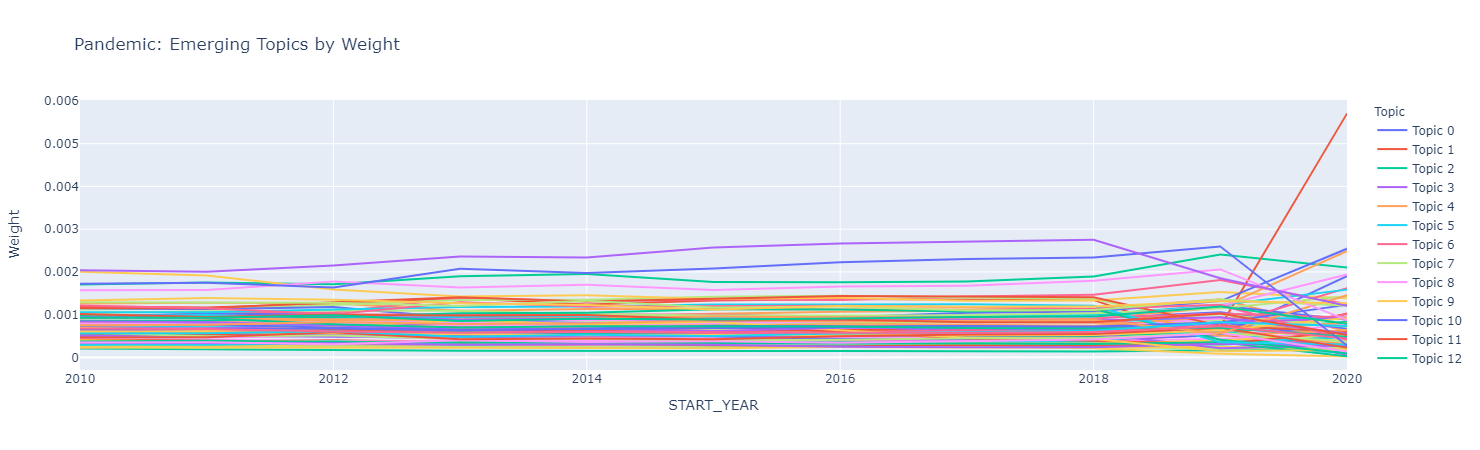

In [227]:
import plotly.express as px

fig = px.line(df2010, x="START_YEAR", y="Weight",color = "Topic", title='Pandemic: Emerging Topics by Weight')
fig.show()

#2nd graph shows the rank!

In [228]:
newrankdf = mergeddf.melt(id_vars =['START_YEAR'], var_name = "Topic", value_name = "Frequency")

In [229]:
newrankdf

,START_YEAR,Topic,Frequency
0,1965,Topic 0,61.0
1,1970,Topic 0,1.0
2,1972,Topic 0,32.0
3,1973,Topic 0,48.0
4,1974,Topic 0,61.0
...,...,...,...
3820,2016,Topic 74,75.0
3821,2017,Topic 74,75.0
3822,2018,Topic 74,75.0
3823,2019,Topic 74,72.0


In [230]:
#Need to change data type for the year
newrankdf['START_YEAR'] = newrankdf['START_YEAR'].astype(int)

In [231]:
#Check
newrankdf['START_YEAR'].dtype

newrankdf

,START_YEAR,Topic,Frequency
0,1965,Topic 0,61.0
1,1970,Topic 0,1.0
2,1972,Topic 0,32.0
3,1973,Topic 0,48.0
4,1974,Topic 0,61.0
...,...,...,...
3820,2016,Topic 74,75.0
3821,2017,Topic 74,75.0
3822,2018,Topic 74,75.0
3823,2019,Topic 74,72.0


In [232]:
newrankdf.to_csv('../../src/emerging_topics/RANK_pandemics_thirtytopics.csv')

In [233]:
#Mask to select year
#MASK TO GET 2000 and up
mask2000 = newrankdf['START_YEAR'] >= 2000
df2000 = newrankdf[mask2000]
df2000

,START_YEAR,Topic,Frequency
30,2000,Topic 0,39.0
31,2001,Topic 0,32.0
32,2002,Topic 0,28.0
33,2003,Topic 0,39.0
34,2004,Topic 0,39.0
...,...,...,...
3820,2016,Topic 74,75.0
3821,2017,Topic 74,75.0
3822,2018,Topic 74,75.0
3823,2019,Topic 74,72.0


In [234]:
#Mask to select year
mask2010 = newrankdf['START_YEAR'] >= 2010
df2010 = newrankdf[mask2010]
df2010

,START_YEAR,Topic,Frequency
40,2010,Topic 0,21.0
41,2011,Topic 0,21.0
42,2012,Topic 0,19.0
43,2013,Topic 0,21.0
44,2014,Topic 0,21.0
...,...,...,...
3820,2016,Topic 74,75.0
3821,2017,Topic 74,75.0
3822,2018,Topic 74,75.0
3823,2019,Topic 74,72.0


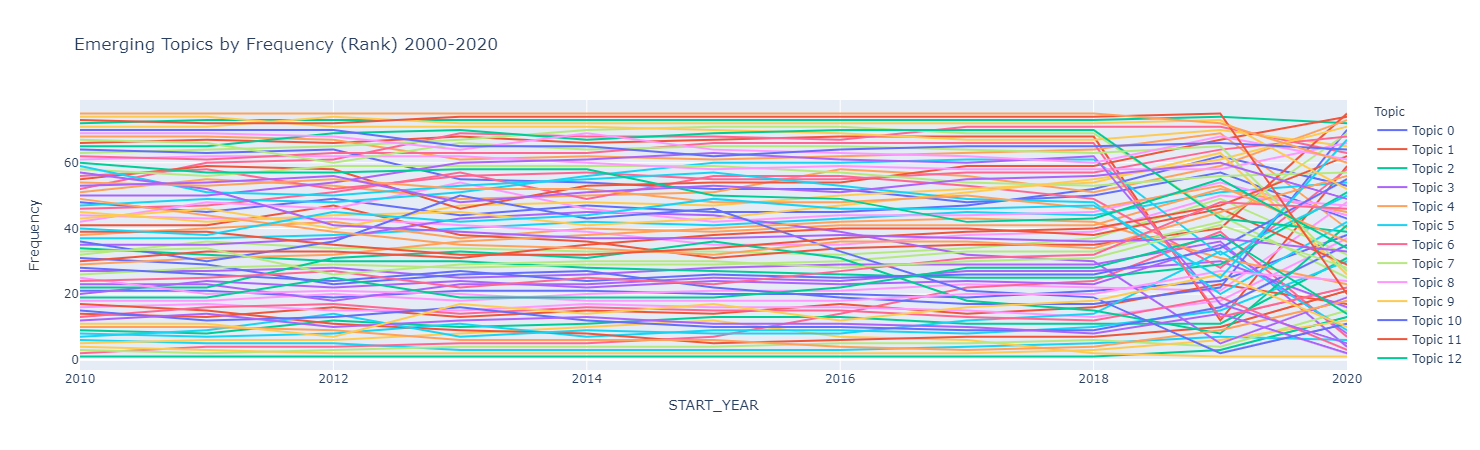

In [235]:
import plotly.express as px

rankfig = px.line(df2010 , x="START_YEAR", y="Frequency",color = "Topic", title='Emerging Topics by Frequency (Rank) 2000-2020')
rankfig.show()
#5 is a more prevalent topic while 1 is the lowest <- need to figure out since it's counter-intuitve rn

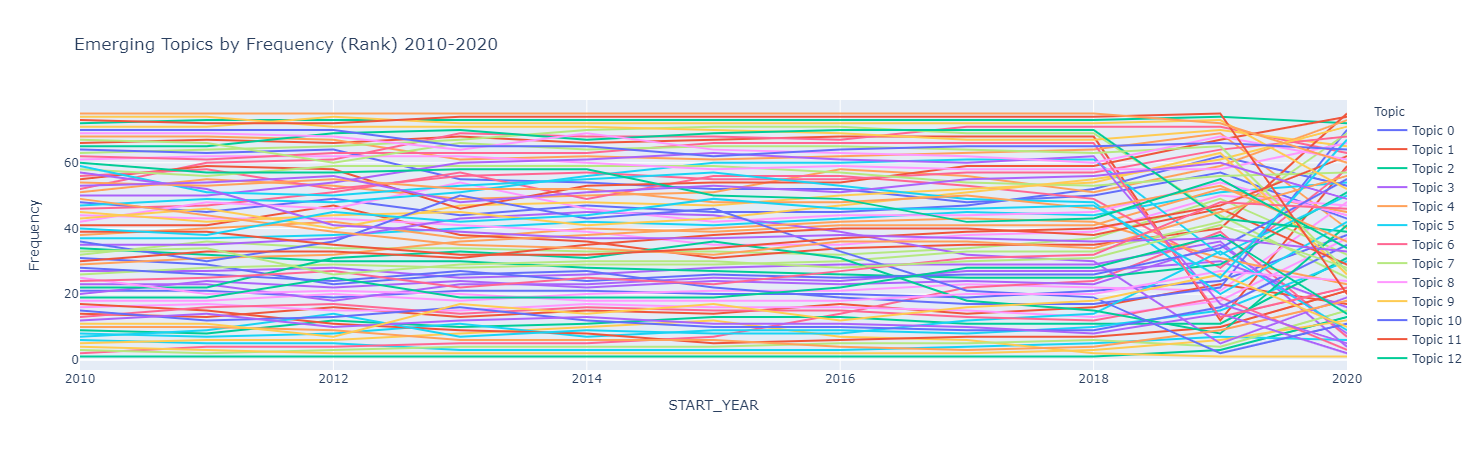

In [236]:
import plotly.express as px

rankfig = px.line(df2010 , x="START_YEAR", y="Frequency",color = "Topic", title='Emerging Topics by Frequency (Rank) 2010-2020')
rankfig.show()
#5 is a more prevalent topic while 1 is the lowest <- need to figure out since it's counter-intuitve rn